In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gen = np.random.default_rng()

In [2]:
A = [1, 2, 3]
B = [3, 1, 2]
categories = ["chores", "finances", "activities"]


In [3]:
def insist(x):
    return [0, 0, 0]


def compromise(x):
    return [1, 1, 1]


def random(x):
    return gen.integers(2, size=3)


def titfortat(x):
    if x[1] == []:
        return [1, 1, 1]
    return x[1][-1]


def grim(x):
    if x[1] == []:
        return [1, 1, 1]
    return np.minimum(x[1][-1], x[0][-1])


def gradual_forgiving(x, n=5):
    if x[1] == []:
        return [1, 1, 1]

    return np.min(x[1][-n:], axis = 0)

strategies = [insist, compromise, titfortat, grim, gradual_forgiving, random]

In [4]:
def game(strategy_A, strategy_B, N):
    choices = [[], []]
    for _ in range(N):
        a = strategy_A(choices)
        b = strategy_B(choices[::-1])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

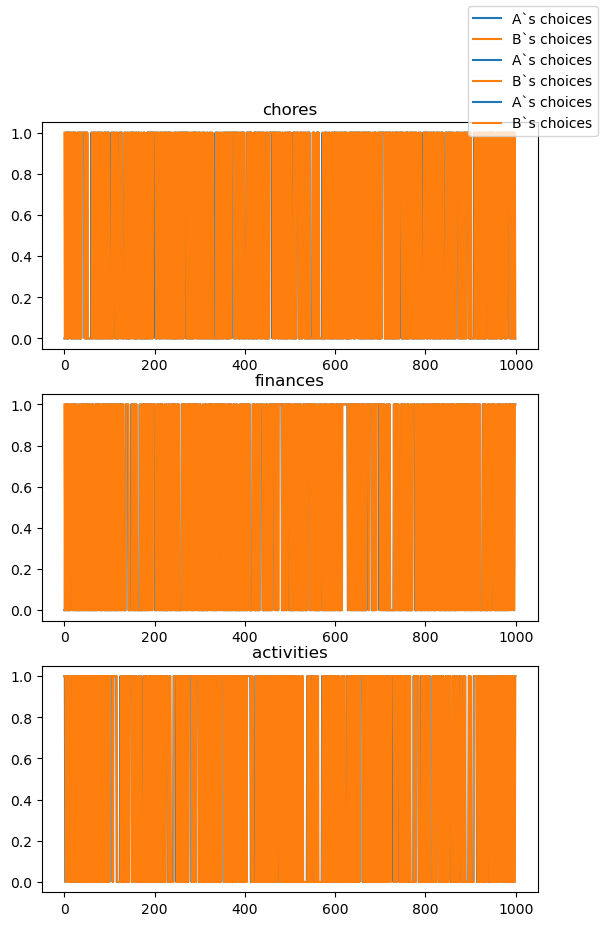

In [5]:
choices = game(random,titfortat,N=1000)
fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i], label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()

In [6]:
subgame_payoffs = np.array([[
    [[0, 0],        [A[i], -B[i]]],
    [[-A[i], B[i]], [1.5, 1.5]]]
    for i in range(3)])


def mean_payoffs(strategy_A, strategy_B, N=10000):
    choices = game(strategy_A, strategy_B, N)
    ret = np.zeros(2)
    for i in range(3):  # subgame
        for j in range(len(choices[0])):  # iteration
            ret += subgame_payoffs[i, choices[i, j, 0], choices[i, j, 1]]
    return np.round(ret/N, 2)

In [7]:
N = 10000

payoffs = []
for i in range(len(strategies)):
    payoffs.append([])
    for j in range(len(strategies)):
        payoffs[-1].append(mean_payoffs(strategies[i], strategies[j], N = N))

In [8]:
labels = [x.__name__ for x in strategies]
df = pd.DataFrame(payoffs, index=labels, columns=labels)
df
# print(df.to_latex())

,insist,compromise,titfortat,grim,gradual_forgiving,random
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0, -0.0]","[0.0, -0.0]","[0.0, -0.0]","[2.98, -2.98]"
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.76, 5.23]"
titfortat,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.09, 1.09]"
grim,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.99, -3.01]"
gradual_forgiving,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.88, -2.76]"
random,"[-2.96, 2.96]","[5.26, -0.8]","[1.14, 1.14]","[-3.02, 3.01]","[-2.76, 2.9]","[1.11, 1.18]"


In [9]:
def stochastic(x, p):
    if x[1] == [] or x[0] == []:
        return [1,1,1]
    p = np.array(p)
    prob = p[2 * np.array(x[0][-1]) + np.array(x[1][-1])]

    return [gen.choice(a=2, p = [1 - prob[i], prob[i]]) for i in range(3)]

In [10]:
p = [0,1,0,1] # p_dd, p_dc, p_cd, p_cc
stoch = lambda x:stochastic(x,p)
game(stoch,grim,N=1000)

array([[[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]]])

In [35]:
def p_evolution(M,N,Q,pruned,rate):
    scores = np.zeros([Q, M])
    p = gen.uniform(size = [M,4])
    p[0] = [0,1,0,1]
    for k in range(Q):
        for i in range(M):
            sA = lambda x: stochastic(x,p[i])
            for sB in strategies:
                payoff = mean_payoffs(sA, sB, N = N)
                scores[k,i] += 2 * payoff[0]
            for j in range(M):
                sB = lambda x: stochastic(x,p[j])
                payoff = mean_payoffs(sA, sB, N = N)
                scores[k,i] += payoff[0]
                scores[k,j] += payoff[1]
        inds = np.argsort(scores[k])
        p[inds[:pruned]] = np.clip(p[inds[-pruned:]] + gen.normal(scale = rate),0,1)
    scores /= 2 * (M + len(strategies))
    return p, scores

In [ ]:
M = 20  # number of strategies
N = 100  # number of rounds each game
Q = 30  # number of iterations
pruned = 5  # number of strategies replaced each generation
evolution_rate = 0.01  # rate of mutation

p, scores = p_evolution(M, N, Q, pruned, evolution_rate)

(30, 10)


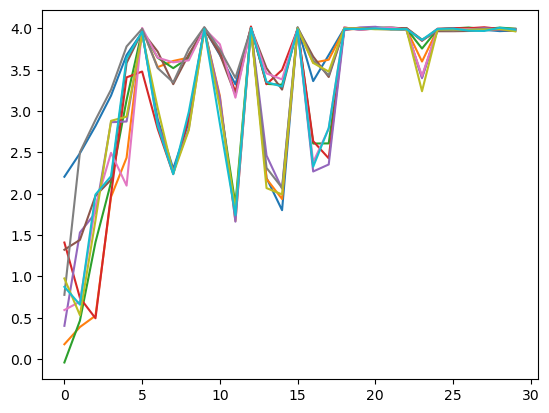

In [ ]:
print(np.shape(scores))
plt.plot(scores)
plt.show()

In [40]:
print(p)

[[0.02508348 0.99866493 0.02508348 0.99866493]
 [0.02641855 1.         0.02641855 1.        ]
 [0.00673552 1.         0.00673552 1.        ]
 [0.01177314 1.         0.01177314 1.        ]
 [0.03590069 1.         0.03590069 1.        ]
 [0.01043807 0.99866493 0.01043807 0.99866493]
 [0.03456561 0.99866493 0.03456561 0.99866493]
 [0.04044546 1.         0.04044546 1.        ]
 [0.03911039 0.99866493 0.03911039 0.99866493]
 [0.00540045 0.99866493 0.00540045 0.99866493]]
